# Enunciado Exercício 6_7 Busca Multimodal por Embedding

Neste exercício, vamos nos utilizar de modelos de processamento de imagem e texto pré-treinados como geradores de embedding. A tarefa é alinhar esses embeddings, de forma que conceitos textuais produzam embeddings similares a imagens correspondentes. Por exemplo, o embedding produzido pela palavra "car" deve ser similar ao embedding de uma imagem de um carro.

A partir deste treinamento, conseguimos implementar uma busca de imagens por query textual!

## Objetivos Específicos
1) Dados: Implemente o DataLoader do dataset fornecido e comente sobre o batch.

2) Arquitetura: Projetar Embeddings de modelos pré-treinados *congelados* para um espaço comum com projeções lineares.

3) Treino: Inicialmente, treinar alinhamento de Embeddings com Mean Square Error (MSE), que alinha somente pares positivos, computando e reportando também o Cosine Similarity.

4) Busca: Implementar query de busca, retornando a imagem correspondente a uma string a partir do Cosine Similarity como medida de similaridade.

5) Melhorar Treinamento: Implementar e treinar com Contrastive Loss, seguindo implementação do paper CLIP leitura dessa semana. A Contrastive Loss deve minimizar a similaridade entre pares de embeddings negativos e maximizar a similaridade entre pares positivos. **Cuidado com composição do batch para Contrastive Loss! Um par de cada classe no máximo**.

6) Busca: Verificar se resultados qualitativos de busca são melhorados com treino com Contrastive Loss.

Dica: guardar os embeddings pré-computados acelera a busca e até o treino.

### Objetivos *Opcionais*
1) (**desafio**) Estratégia de treinamento do SIGLip resolveria o problema de repetições no batch?
2) Modificar busca para retornar resultados rankeados.
3) Usar o CLIP pré-treinado (sem nenhum ajuste) para realizar a busca.


# Exemplo de resultado esperado, com treino com MSE Loss, para query "car"
Similarity: Cosine Similarity entre Embeddings de Imagem projetadas e de Texto



Note que treinando com MSE Loss, embora a resposta esteja correta, a cosine similarity entre pares negativos ainda é alta.

Em teoria, o treino com contrastive loss deve diminuir a similaridade entre pares negativos.

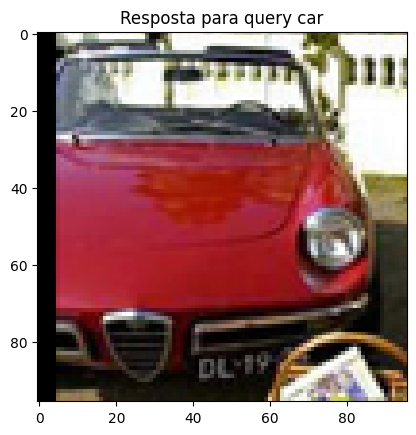

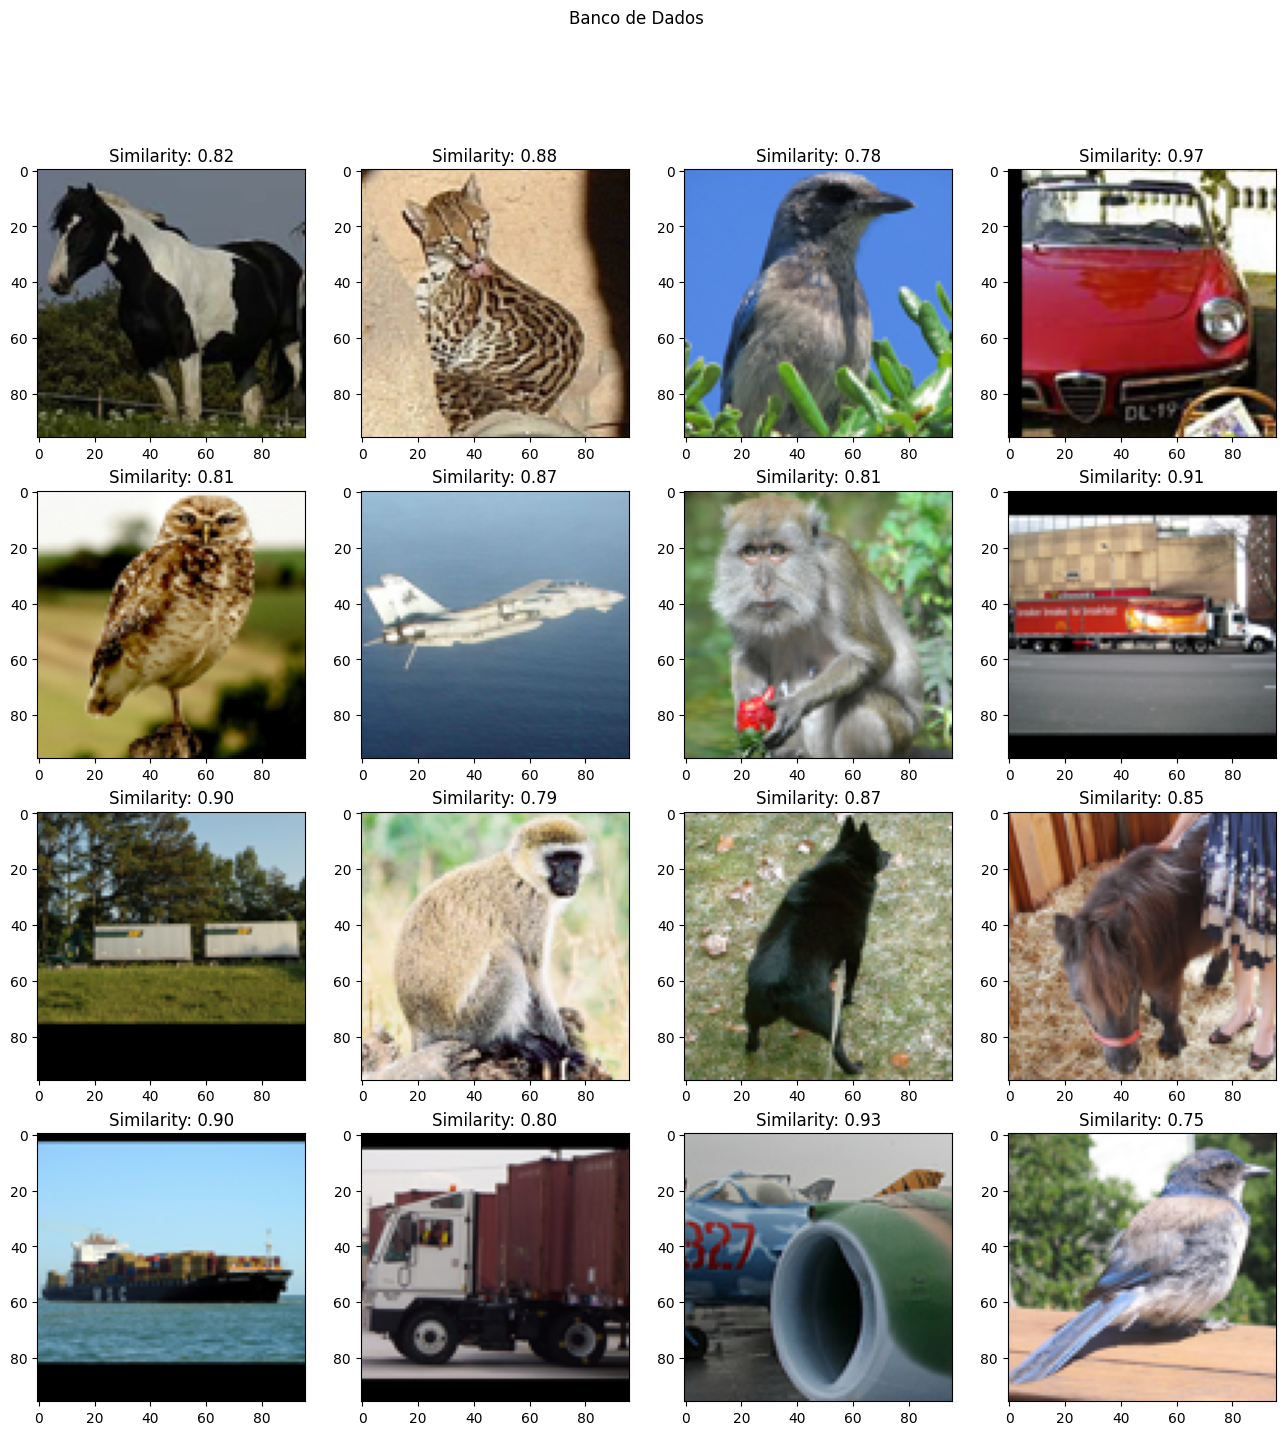

# Imports e bibliotecas

In [ ]:
!pip install torchinfo efficientnet-pytorch -q

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import math
import pandas as pd
import torch
import random
import logging
import torchinfo
from torch import nn
from pprint import pprint
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10
from transformers import BertModel, BertTokenizer
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np

# Dataset
Implementação do dataset de pares de imagens e textos

In [ ]:
class STLDataset(Dataset):
    '''
    Dataset pronto para treino com MSE Loss

    CUIDADO: Não está correto para contrastive loss!
    '''
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    def __init__(self, mode: str, text_model: str, transform: object):
        self.dataset = STL10(root='./data', split='train' if mode == "train" else "test",  transform=transform, download=True)
        self.classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

        self.tokenizer = BertTokenizer.from_pretrained(text_model)
        print(f"Initialized {mode} data.")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        image, label = self.dataset[i]
        text = self.classes[label]

        text_tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"][0]

        return {"image": image,
                "label": label,
                "text": text,
                "text_tokens": text_tokens}

text_model = "bert-base-uncased"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=STLDataset.MEAN, std=STLDataset.STD)])
train_data = STLDataset("train", text_model, transform)
val_data = STLDataset("val", text_model, transform)

100%|██████████| 2.64G/2.64G [03:19<00:00, 13.2MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Initialized train data.
Initialized val data.


## Debug do Dataset

In [ ]:
# TODO
sample = train_data[0]  # pega o primeiro item

print("Image shape:", sample["image"].shape)
print("Label:", sample["label"])
print("Text:", sample["text"])
print("Text tokens shape:", sample["text_tokens"].shape)
print("Text tokens:", sample["text_tokens"])


Image shape: torch.Size([3, 96, 96])
Label: 1
Text: bird
Text tokens shape: torch.Size([3])
Text tokens: tensor([ 101, 4743,  102])


## DataLoader e Debug do DataLoader


In [ ]:
# Cria os dataloaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

In [ ]:
batch = next(iter(train_loader))
print("Images shape:", batch["image"].shape)         # (32, 3, 96, 96)
print("Labels shape:", batch["label"].shape)         # (32,)
print("Texts length:", len(batch["text"]))            # 32
print("Text tokens shape:", batch["text_tokens"].shape)  # (32, max_seq_len)


Images shape: torch.Size([32, 3, 96, 96])
Labels shape: torch.Size([32])
Texts length: 32
Text tokens shape: torch.Size([32, 3])


# Arquitetura

Utilizamos modelos pré-treinados congelados e treinamos uma camada de projeção de um Embedding para o espaço do outro.

O design aqui é livre e você pode experimentar com modelos pré-treinados diferentes, mais de uma projeção linear, não congelar um dos modelos grandes (pesado), etc.

In [ ]:
class ImageModel(nn.Module):
    def __init__(self, image_model: str = "efficientnet-b0", freeze: bool = True, emb_size = 512):
        super().__init__()

        # Gerador de Embeddings a partir de imagens
        self.image_model = EfficientNet.from_pretrained(image_model)


        # Número de features da última camada
        in_features = self.image_model._fc.in_features


        # Congelamento do modelo
        if freeze:
            for name, param in self.image_model.named_parameters():
                if not name.startswith("_fc"):  # mantém apenas projeção treinável
                    param.requires_grad = False

        # Pesos de projeção dos embeddings não são congelados!
        # Dica: uma boa representação linear da imagem é a entrada da camda Fully Connected da EfficientNet que classifica imagens.
        # Neste exemplo, substituimos ela por nossa projeção para o tamanho de embedding do BERT (emb_size)
        self.image_model._fc = nn.Linear(in_features, emb_size)

    def forward(self, x):
        features = self.image_model(x)                  # extrai features da EfficientNet

        # Normalizar pra evitar que magnitudes diferentesdistorçam a similiridade
        embeddings = features / features.norm(dim=-1, keepdim=True)  # normalização L2
        return embeddings

In [ ]:
class TextModel(nn.Module):
    # *args e **kwargs é uma representação genérica de argumentos, substitua pelo seu design.
    def __init__(self, text_model = text_model, freeze = True, emb_size = 512):
        super().__init__()

        self.text_model = BertModel.from_pretrained(text_model)

        # Embedding de saída do  BERT
        hidden_size = self.text_model.config.hidden_size

        # Camada de projeção
        self.projection = nn.Linear(hidden_size, emb_size)

        # Congela as camadas do modelo, exceto a projeção
        if freeze:
            for param in self.text_model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask=None):
        # Forward do BERT
        outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)

        # Pega o embedding [CLS] (posição 0 do hidden state da última camada)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (batch, hidden_size)

        embeddings = self.projection(cls_embedding)

        # Faz a normalização
        embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)

        return embeddings

## Implementação da arquitetura multimodal
Vamos unir instâncias das classes de interpretação de imagem e texto acima para retornar os dois embeddings pareados para treino.

In [ ]:
class Multimodal(nn.Module):
    def __init__(self, image_model = "efficientnet-b0", text_model = text_model, emb_size = 512, freeze_vision = True, freeze_text = True):
        super().__init__()
        # TODO Inicializar o ImageModel, TextModel, ajuste parâmetros para sua preferência
        self.image_model = ImageModel(image_model, freeze_vision, emb_size)
        self.text_model = TextModel(text_model, freeze_text, emb_size)
        self.emd_size = emb_size

    def forward(self, batch):
        # TODO computar embeddings de imagem projetados e alinhados com o de texto
        # DICA: inclua asserts para garantir que os dois embeddings tem a mesma dimensão

        # Extrai embeddings
        image_emb = self.image_model(batch["image"])
        text_emb = self.text_model(batch["text_tokens"])

        # Assert de alinahmento de embeddings
        assert image_emb.shape[1] == text_emb.shape[1], \
            f"Embeddings desalinhados: {image_emb.shape} vs {text_emb.shape}"

        return image_emb, text_emb

## Visualização dos parâmetros
Visualize a arquitetura para checar se está correta

In [ ]:
 torchinfo.summary(Multimodal(), depth=3)

Loaded pretrained weights for efficientnet-b0


Layer (type:depth-idx)                                            Param #
Multimodal                                                        --
├─ImageModel: 1-1                                                 --
│    └─EfficientNet: 2-1                                          --
│    │    └─Conv2dStaticSamePadding: 3-1                          (864)
│    │    └─BatchNorm2d: 3-2                                      (64)
│    │    └─ModuleList: 3-3                                       (3,594,460)
│    │    └─Conv2dStaticSamePadding: 3-4                          (409,600)
│    │    └─BatchNorm2d: 3-5                                      (2,560)
│    │    └─AdaptiveAvgPool2d: 3-6                                --
│    │    └─Dropout: 3-7                                          --
│    │    └─Linear: 3-8                                           655,872
│    │    └─MemoryEfficientSwish: 3-9                             --
├─TextModel: 1-2                                                  -

# Treinamento com MSELoss
Implemente o treinamento, primeiro utilizando MSELoss

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# Inicializa modelo multimodal
model = Multimodal(image_model="efficientnet-b0", text_model="bert-base-uncased", emb_size=512, freeze_vision=True, freeze_text=True)

Loaded pretrained weights for efficientnet-b0


In [ ]:
import time
import random
import torch.optim as optim

from torch.nn import MSELoss
mse_loss = MSELoss()

random.seed(42)
epochs = 10
lr = 5e-5

model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr)

cosine_sim = nn.CosineSimilarity(dim=-1)

In [ ]:
for epoch in range(epochs):
    start_time = time.time()  # Start time of the epoch
    epoch_loss = 0
    total_samples = 0
    model.train()
    for batch in train_loader:

        images = batch["image"].to(device)
        input_ids = batch["text_tokens"].to(device)
        #attention_mask = batch["attention_mask"].to(device)

        # Forward pass
        image, text = model({
            "image": images,
            "text_tokens": input_ids,
            #"attention_mask": attention_mask
        })

        loss = mse_loss(image, text)

        # Backward
        # Zerando os gradiente calculados
        optimizer.zero_grad()
        # Fazendo calculo de backpropagation
        loss.backward()
        # Atualizando os pesos do modelo
        optimizer.step()

        epoch_loss+= loss.detach() * images.size(0)
        total_samples += images.size(0)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of epoch
    avg_epoch_loss = epoch_loss / total_samples


    print('Training Data:')
    print(f'Epoch [{epoch+1}/{epochs}], \
            Loss: {avg_epoch_loss.item():.4f},\
            Elapsed Time: {epoch_duration:.2f} sec')

    model.eval()

    total_loss = 0.0
    total_samples = 0
    cosine_sims = []

    with torch.no_grad():
        for batch in val_loader:

          images = batch["image"].to(device)
          input_ids = batch["text_tokens"].to(device)
          #attention_mask = batch["attention_mask"].to(device)

          # Forward pass
          image, text = model({
            "image": images,
            "text_tokens": input_ids,
            #"attention_mask": attention_mask
          })

          loss = mse_loss(image, text)

          sims = cosine_sim(image, text)  # última batch
          cosine_sims.append(sims.mean().item())

          batch_size = images.size(0)
          total_loss += loss.detach() * batch_size
          total_samples += batch_size

        avg_loss = total_loss / total_samples
        avg_cosine = sum(cosine_sims) / len(cosine_sims)

    print("Validation Data:")
    print(f"Loss: {avg_loss.item():.4f}, "
          f"Cosine Similarity: {avg_cosine:.4f}")



Training Data:
Epoch [1/10],             Loss: 0.0006,            Elapsed Time: 168.20 sec
Validation Data:
Loss: 0.0008, Cosine Similarity: 0.8072
Training Data:
Epoch [2/10],             Loss: 0.0004,            Elapsed Time: 167.43 sec
Validation Data:
Loss: 0.0006, Cosine Similarity: 0.8415
Training Data:
Epoch [3/10],             Loss: 0.0004,            Elapsed Time: 167.43 sec
Validation Data:
Loss: 0.0005, Cosine Similarity: 0.8606
Training Data:
Epoch [4/10],             Loss: 0.0003,            Elapsed Time: 167.54 sec
Validation Data:
Loss: 0.0005, Cosine Similarity: 0.8729
Training Data:
Epoch [5/10],             Loss: 0.0003,            Elapsed Time: 167.35 sec
Validation Data:
Loss: 0.0005, Cosine Similarity: 0.8776
Training Data:
Epoch [6/10],             Loss: 0.0002,            Elapsed Time: 168.05 sec
Validation Data:
Loss: 0.0004, Cosine Similarity: 0.8880
Training Data:
Epoch [7/10],             Loss: 0.0002,            Elapsed Time: 167.40 sec
Validation Data:
Loss

# Query
Com um batch de imagens e uma string única de query, retorne qual a imagem correspondente usando Cosine Similarity (exemplo de saída esperada no início do notebook)

Faça debugs e confirme que está funcionando corretamente..

In [ ]:
import torch
import torch.nn as nn

def query(multimodal_model: Multimodal,
          query: str,
          images: torch.Tensor,
          tokenizer,
          device=torch.device("cpu")):
    multimodal_model.eval()

    # Processa o texto
    encoded = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=32)
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    #  Move imagens para device
    images = images.to(device)

    with torch.no_grad():
        # Forward no modelo
        image_emb, text_emb = multimodal_model({
            "image": images,
            "text_tokens": input_ids.repeat(images.size(0), 1),  # repete o texto para todas as imagens
            "attention_mask": attention_mask.repeat(images.size(0), 1)
        })

        # Cosine similarity
        cosine_sim = nn.CosineSimilarity(dim=-1)
        similarities = cosine_sim(image_emb, text_emb)

    return similarities


In [ ]:
tokenizer = BertTokenizer.from_pretrained(text_model)

In [ ]:
images = next(iter(val_loader))
images["image"]

tensor([[[[ 1.7694,  1.7694,  1.7523,  ...,  1.8037,  1.7865,  1.8037],
          [ 1.7694,  1.7523,  1.7865,  ...,  1.7865,  1.8037,  1.7865],
          [ 1.7694,  1.7694,  1.7694,  ...,  1.7865,  1.8037,  1.8037],
          ...,
          [ 1.6838,  1.7694,  1.8379,  ...,  0.7933,  1.2385,  1.2899],
          [ 1.8722,  1.5297,  1.3413,  ...,  1.3584,  1.4098,  1.2043],
          [ 1.7180,  1.7352,  1.7180,  ...,  1.2385,  0.9474,  0.8618]],

         [[ 2.0784,  2.0784,  2.0959,  ...,  2.0434,  2.0609,  2.0784],
          [ 2.0784,  2.0784,  2.0784,  ...,  2.0434,  2.0434,  2.0609],
          [ 2.0784,  2.0959,  2.0959,  ...,  2.0434,  2.0434,  2.0434],
          ...,
          [ 1.0105,  1.1856,  1.2206,  ...,  0.5378,  0.8179,  0.8880],
          [ 1.3256,  1.0105,  0.8179,  ...,  0.9055,  0.8880,  0.7304],
          [ 1.1331,  1.1856,  1.1856,  ...,  0.6429,  0.5203,  0.3803]],

         [[ 2.3263,  2.3263,  2.3263,  ...,  2.3088,  2.3088,  2.2914],
          [ 2.3263,  2.3263,  

In [ ]:
# Supondo que `model` é seu Multimodal e `images` é um batch de imagens
query_text = "airplane"
batch = next(iter(val_loader))
images = batch["image"]
similarities = query(model, query_text, images, tokenizer)

# Mostra as top-5 imagens mais similares
topk = torch.topk(similarities, k=5)
print("Top-5 indices:", topk.indices)
print("Top-5 similaridades:", topk.values)


Top-5 indices: tensor([ 5, 30, 16, 28,  4])
Top-5 similaridades: tensor([0.9957, 0.9954, 0.9940, 0.9938, 0.9933])


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# --- Função para exibir imagens ---
def show_images(images_tensor, indices, title_list=None):
    """
    images_tensor: tensor (B, 3, H, W)
    indices: lista de índices para exibir
    title_list: lista opcional de títulos para cada imagem
    """
    n = len(indices)
    plt.figure(figsize=(4*n, 4))
    for i, idx in enumerate(indices):
        img = images_tensor[idx].cpu()
        # Denormaliza (opcional, se imagens foram normalizadas)
        img = img * torch.tensor(STLDataset.STD).view(3,1,1) + torch.tensor(STLDataset.MEAN).view(3,1,1)
        img = img.clamp(0,1)
        img = img.permute(1,2,0)  # C,H,W -> H,W,C

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        if title_list:
            plt.title(title_list[i])
    plt.show()


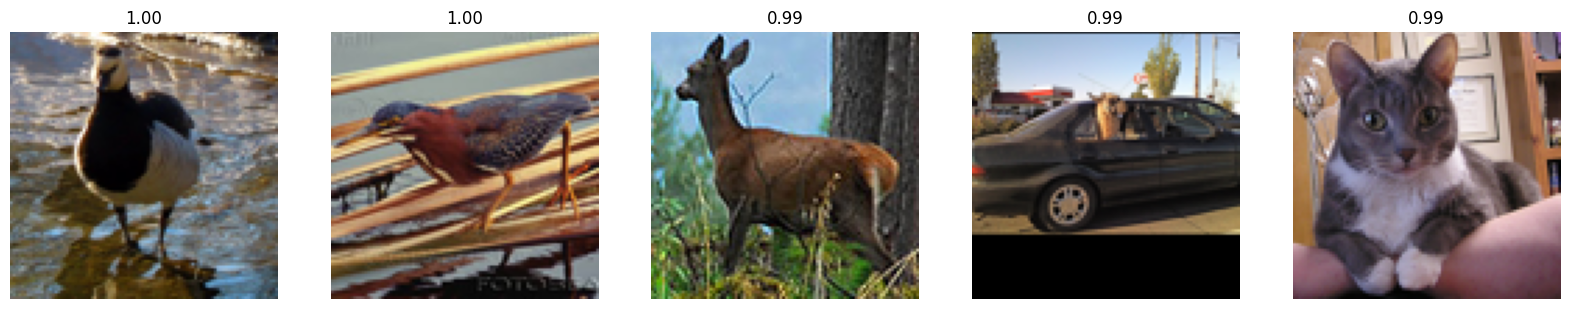

In [ ]:
show_images(images, topk.indices, title_list=[f"{similarities[idx]:.2f}" for idx in topk.indices])

# Treinamento com  Contrastive Loss
Implemente contrastive loss inspirada pelo CLIP e treine novamente

In [ ]:
def contrastive_loss():
    raise NotImplementedError

# TODO treinar

# Query com modelo treinado com Contrastive Loss

Espera-se que as Cosine Similarities sejam mais próximas de zero para pares negativos!

In [ ]:
# TODO